# Particle Physics Event Classification

## Conjunto de datos: Particle Physics Event Classification Dataset

### Descripción
Accurately separating rare signal (s) events from abundant background (b) is central to particle physics.
This dataset provides reconstructed kinematic features per event, along with a per-event Weight to reflect experimental importance. The task is binary classification: predict whether an event is signal (s) or background (b).

Descarga de los ficheros
https://www.kaggle.com/datasets/younusmohamed/particle-physics-event-classification-dataset

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

## Funciones axiliares

In [2]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [3]:
def train_val_test_split_deep(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.02, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [4]:
# Función que separa las variables de entrada y salida
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [5]:
# Transformador diseñado para escalar de manera sencilla únicamente unas columnas seleccionadas
class CustomScalerR(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        scale_attrs = X_copy[self.attributes]
        robust_scaler = RobustScaler()
        X_scaled = robust_scaler.fit_transform(scale_attrs)
        X_scaled = pd.DataFrame(X_scaled, columns=self.attributes, index=X_copy.index)
        for attr in self.attributes:
            X_copy[attr] = X_scaled[attr]
        return X_copy

In [6]:
# Transformador diseñado para escalar de manera sencilla únicamente unas columnas seleccionadas
class CustomScalerMinMax(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        scale_attrs = X_copy[self.attributes]
        minmax_scaler = MinMaxScaler()
        X_scaled = minmax_scaler.fit_transform(scale_attrs)
        X_scaled = pd.DataFrame(X_scaled, columns=self.attributes, index=X_copy.index)
        for attr in self.attributes:
            X_copy[attr] = X_scaled[attr]
        return X_copy

# Particle Event Classification: Logistic Regression

## 1. Lectura del conjunto de datos

In [7]:
df = pd.read_csv("Particle Physics Event Classification.csv")

## 2. Visualización preliminar de la información

In [8]:
df

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,9.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,349995,-999.000,71.989,36.548,5.042,-999.00,-999.000,-999.000,1.392,5.042,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,4.505083,b
249996,349996,-999.000,58.179,68.083,22.439,-999.00,-999.000,-999.000,2.585,22.439,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,2.497259,b
249997,349997,105.457,60.526,75.839,39.757,-999.00,-999.000,-999.000,2.390,22.183,...,1,41.992,1.800,-0.166,-999.000,-999.00,-999.000,41.992,0.018636,s
249998,349998,94.951,19.362,68.812,13.504,-999.00,-999.000,-999.000,3.365,13.504,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.681611,b


In [9]:
# Se coloca la columna "EventId como indice"
df = df.set_index("EventId")

In [10]:
df.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,-49.023079,49.239819,81.181982,57.895962,-708.416643,-601.237051,-709.356603,2.373100,18.917332,158.432217,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,406.345647,35.344886,40.828691,63.655682,454.482458,657.972302,453.019877,0.782911,22.273494,115.706115,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,46.104000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,77.550000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.018636
50%,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,120.664500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,200.478250,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,1192.026000,690.075000,1349.351000,2834.999000,9.000000,4974.979000,16.690000,5.684000,2834.999000,1852.462000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 100000 to 349999
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DER_mass_MMC                 250000 non-null  float64
 1   DER_mass_transverse_met_lep  250000 non-null  float64
 2   DER_mass_vis                 250000 non-null  float64
 3   DER_pt_h                     250000 non-null  float64
 4   DER_deltaeta_jet_jet         250000 non-null  float64
 5   DER_mass_jet_jet             250000 non-null  float64
 6   DER_prodeta_jet_jet          250000 non-null  float64
 7   DER_deltar_tau_lep           250000 non-null  float64
 8   DER_pt_tot                   250000 non-null  float64
 9   DER_sum_pt                   250000 non-null  float64
 10  DER_pt_ratio_lep_tau         250000 non-null  float64
 11  DER_met_phi_centrality       250000 non-null  float64
 12  DER_lep_eta_centrality       250000 non-null  float64
 13 

In [12]:
# Variables categoricas
df["PRI_jet_num"].value_counts()

PRI_jet_num
0    99913
1    77544
2    50379
3    22164
Name: count, dtype: int64

In [13]:
# Se tienen 164333 cuentas de background y 85667 cuentas de señales
df["Label"].value_counts()

Label
b    164333
s     85667
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

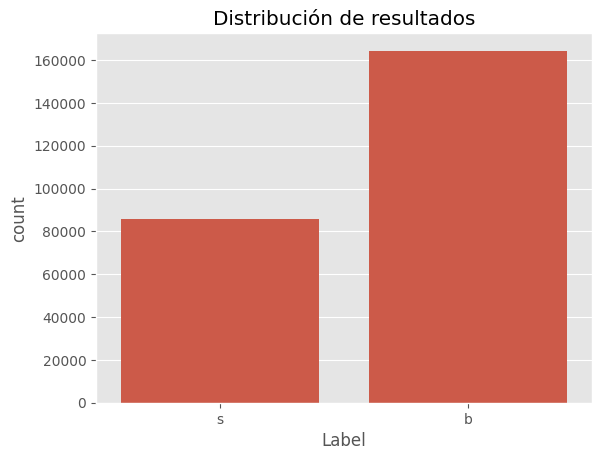

In [14]:
sns.countplot(x="Label", data=df)
plt.title("Distribución de resultados")
plt.show

In [15]:
# Se verifica si hay valores nulos
df.isna().any()

DER_mass_MMC                   False
DER_mass_transverse_met_lep    False
DER_mass_vis                   False
DER_pt_h                       False
DER_deltaeta_jet_jet           False
DER_mass_jet_jet               False
DER_prodeta_jet_jet            False
DER_deltar_tau_lep             False
DER_pt_tot                     False
DER_sum_pt                     False
DER_pt_ratio_lep_tau           False
DER_met_phi_centrality         False
DER_lep_eta_centrality         False
PRI_tau_pt                     False
PRI_tau_eta                    False
PRI_tau_phi                    False
PRI_lep_pt                     False
PRI_lep_eta                    False
PRI_lep_phi                    False
PRI_met                        False
PRI_met_phi                    False
PRI_met_sumet                  False
PRI_jet_num                    False
PRI_jet_leading_pt             False
PRI_jet_leading_eta            False
PRI_jet_leading_phi            False
PRI_jet_subleading_pt          False
P

In [16]:
# Se verifica si hay valores infinitos
df.isin([np.inf, -np.inf]).any()

DER_mass_MMC                   False
DER_mass_transverse_met_lep    False
DER_mass_vis                   False
DER_pt_h                       False
DER_deltaeta_jet_jet           False
DER_mass_jet_jet               False
DER_prodeta_jet_jet            False
DER_deltar_tau_lep             False
DER_pt_tot                     False
DER_sum_pt                     False
DER_pt_ratio_lep_tau           False
DER_met_phi_centrality         False
DER_lep_eta_centrality         False
PRI_tau_pt                     False
PRI_tau_eta                    False
PRI_tau_phi                    False
PRI_lep_pt                     False
PRI_lep_eta                    False
PRI_lep_phi                    False
PRI_met                        False
PRI_met_phi                    False
PRI_met_sumet                  False
PRI_jet_num                    False
PRI_jet_leading_pt             False
PRI_jet_leading_eta            False
PRI_jet_leading_phi            False
PRI_jet_subleading_pt          False
P

In [17]:
# Se eliminan valores nulos si los hubiera
df.drop_duplicates()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
EventId,,,,,,,,,,,,,,,,,,,,,
100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
100003,143.905,81.417,80.943,0.414,9.00,-999.000,-999.000,3.310,0.414,75.968,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,5.446378,b
100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349995,-999.000,71.989,36.548,5.042,-999.00,-999.000,-999.000,1.392,5.042,55.892,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,4.505083,b
349996,-999.000,58.179,68.083,22.439,-999.00,-999.000,-999.000,2.585,22.439,50.618,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,2.497259,b
349997,105.457,60.526,75.839,39.757,-999.00,-999.000,-999.000,2.390,22.183,120.462,...,1,41.992,1.800,-0.166,-999.000,-999.00,-999.000,41.992,0.018636,s


## 3. Boxplots e Histogramas

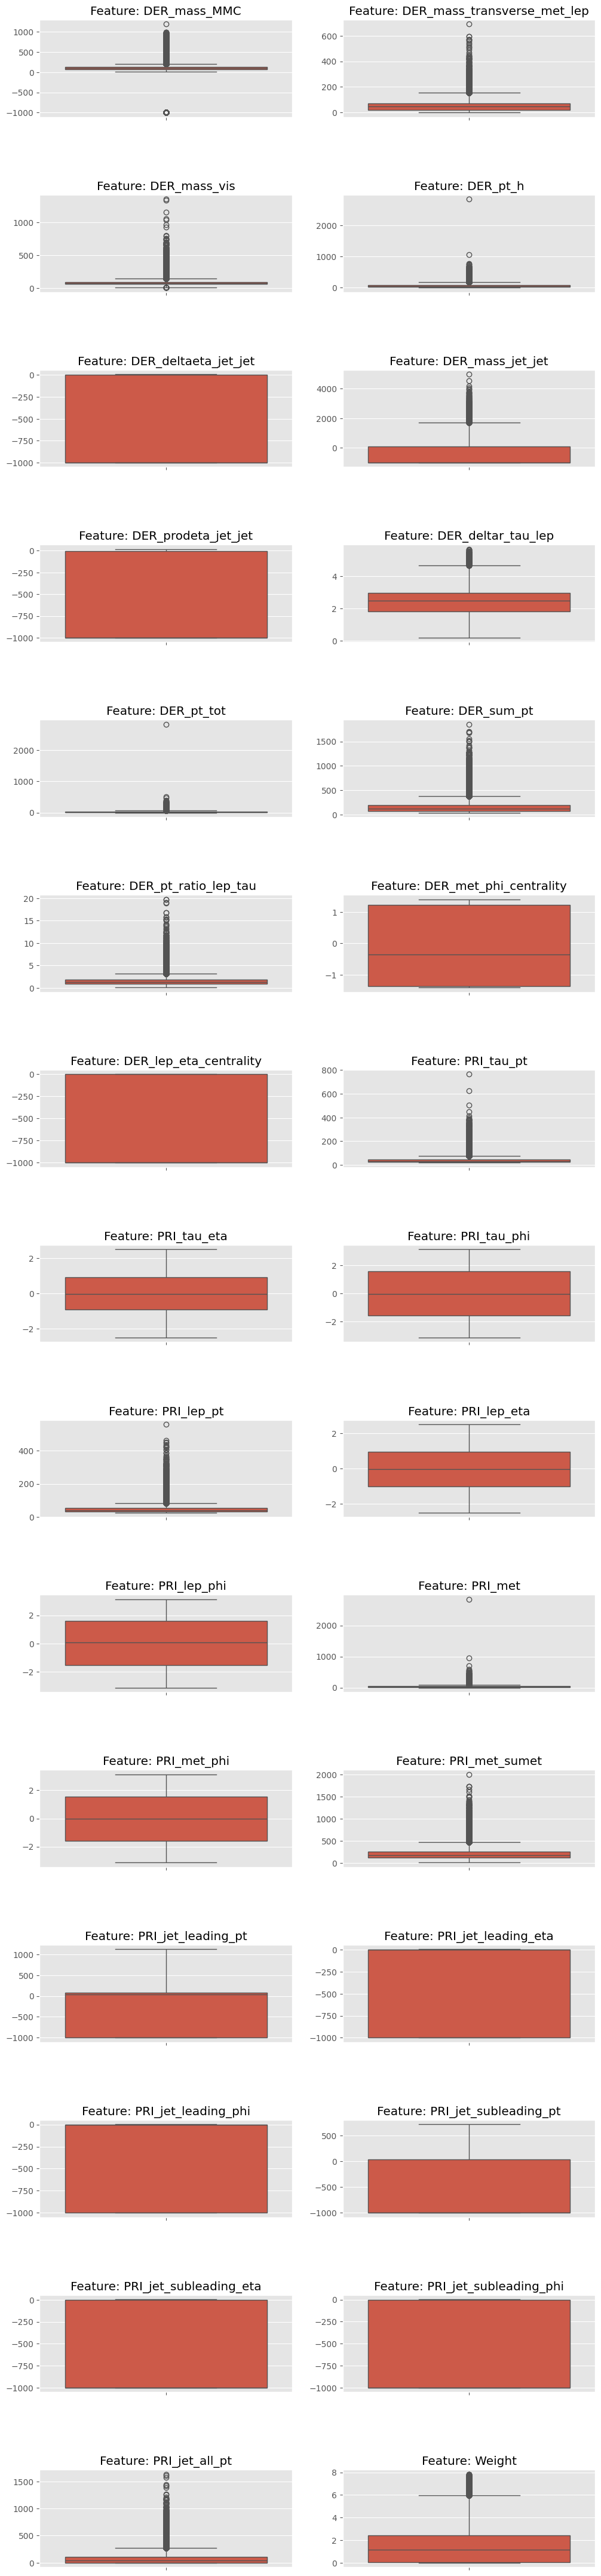

In [18]:
# Boxplots
features = df.drop(["Label", "PRI_jet_num"], axis=1)

plt.figure(figsize=(12, 120))
gs = gridspec.GridSpec(32, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Boxplots por clase
    sns.boxplot(data=df[f], ax=ax)
    ax.set_ylabel('')
    ax.set_title(f"Feature: {f}")

plt.show()

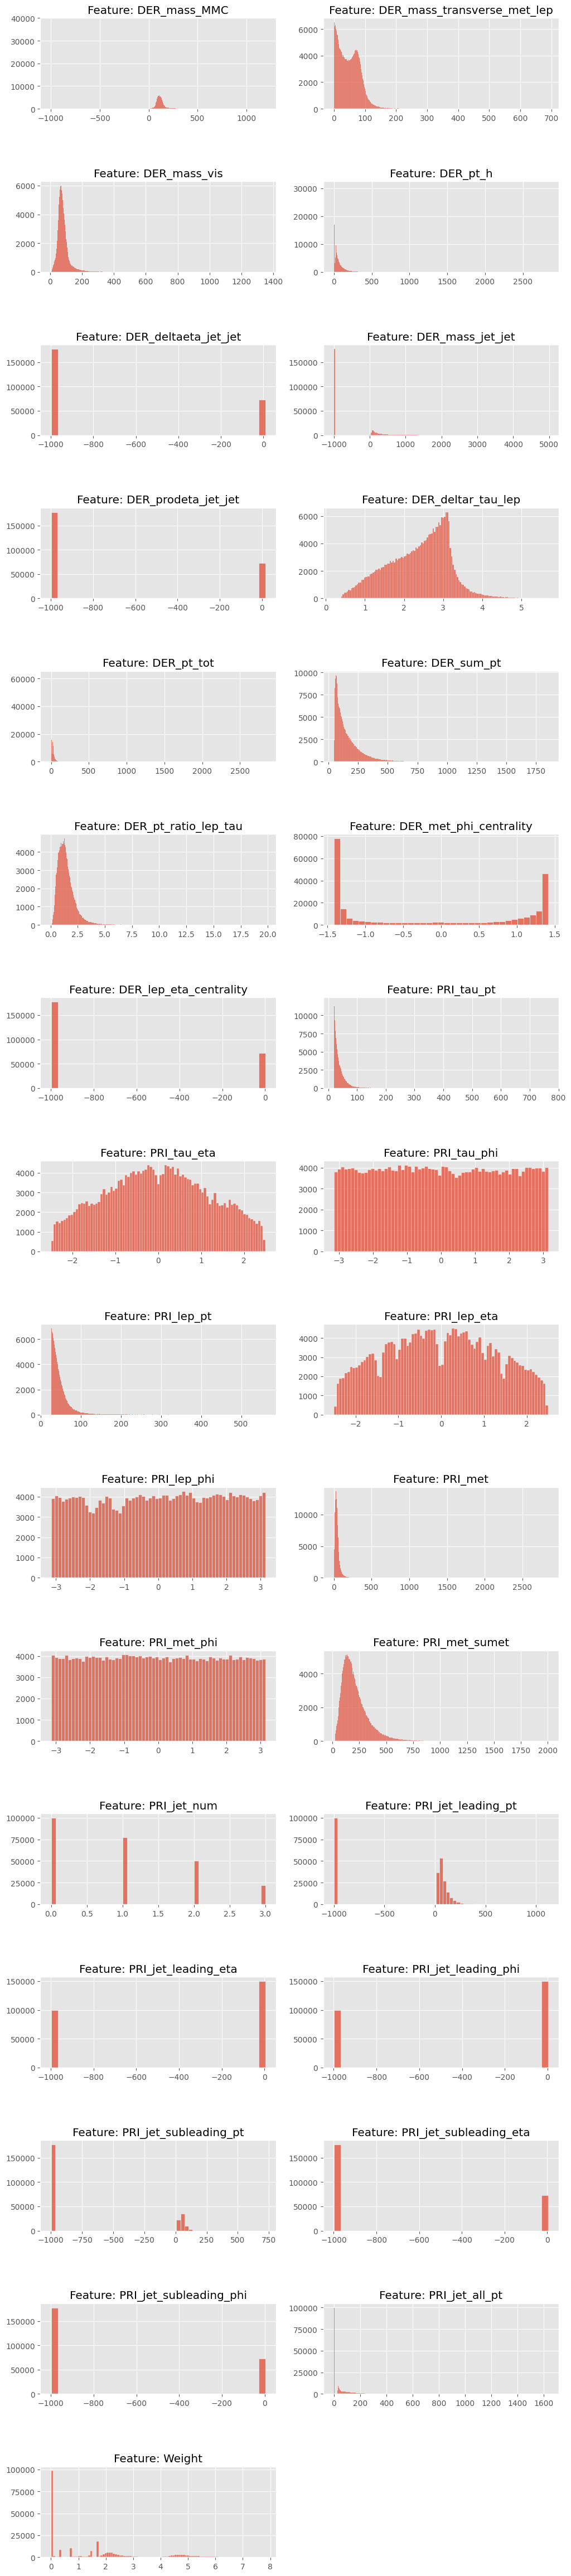

In [19]:
# Histogramas
features = df.drop(["Label"], axis=1)

plt.figure(figsize=(12, 120))
gs = gridspec.GridSpec(32, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Histogramas por clase
    sns.histplot(data=df[f], ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f}")

plt.show()

## 4. Comparacion de la variable de salida

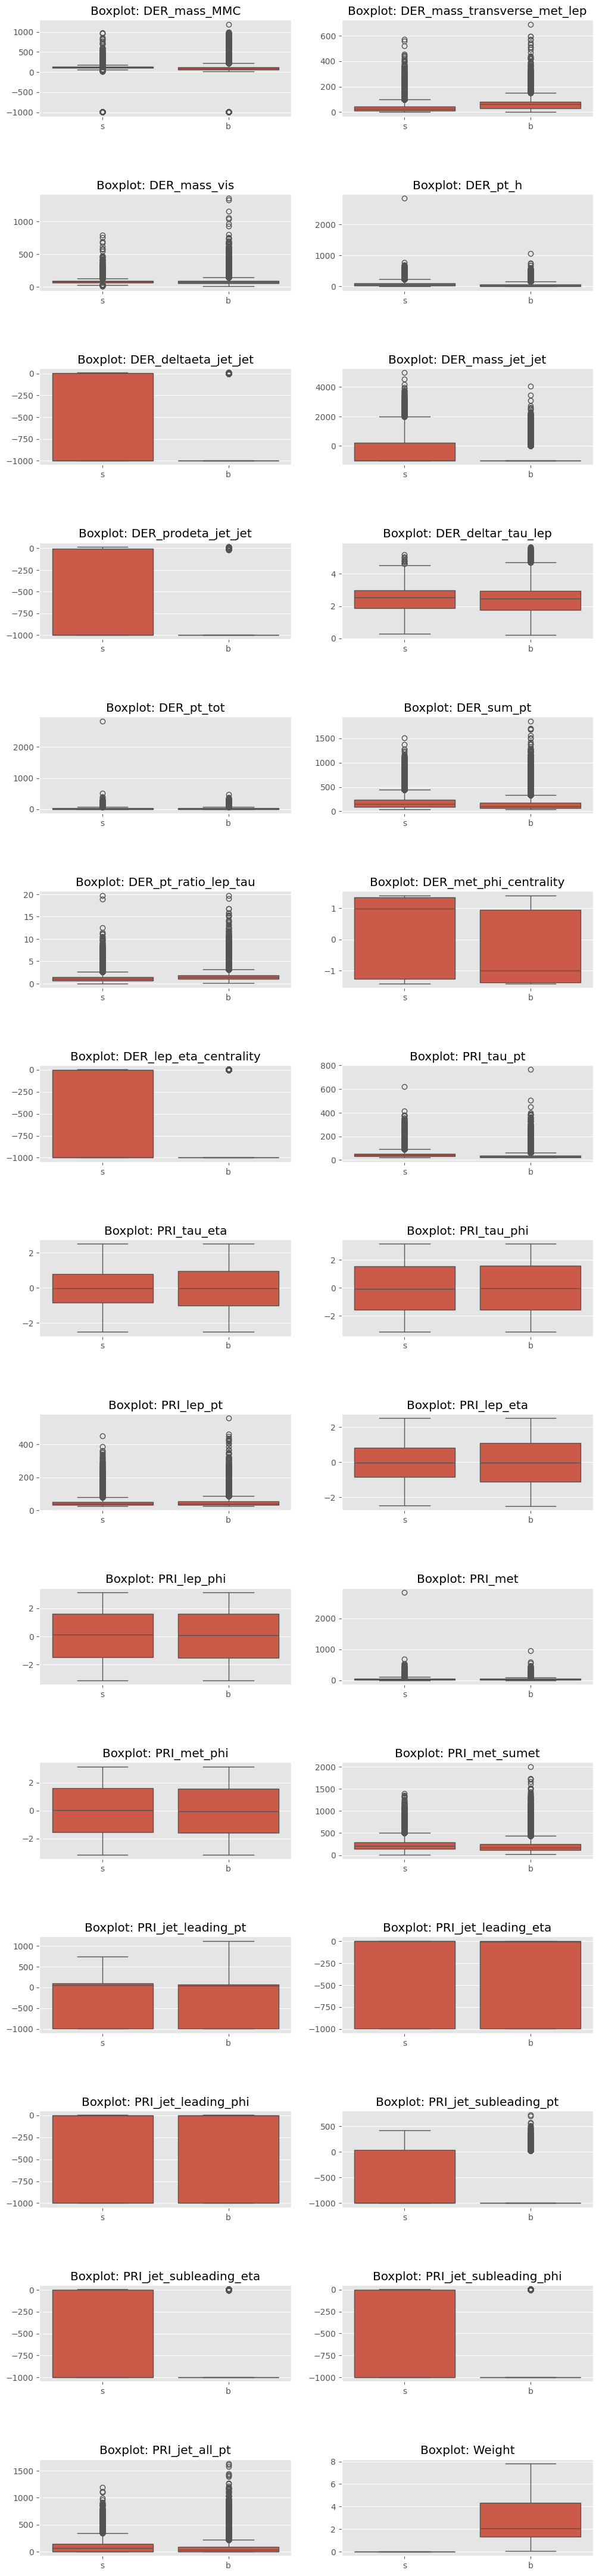

In [20]:
# Comparacion via Boxplot
features = df.drop(["Label", "PRI_jet_num"], axis=1)

plt.figure(figsize=(12, 120))
gs = gridspec.GridSpec(32, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.boxplot(data=df, x="Label", y=f, ax=ax)
    ax.set_xlabel('')  
    ax.set_ylabel('') 
    ax.set_title(f"Boxplot: {f}")

plt.show()

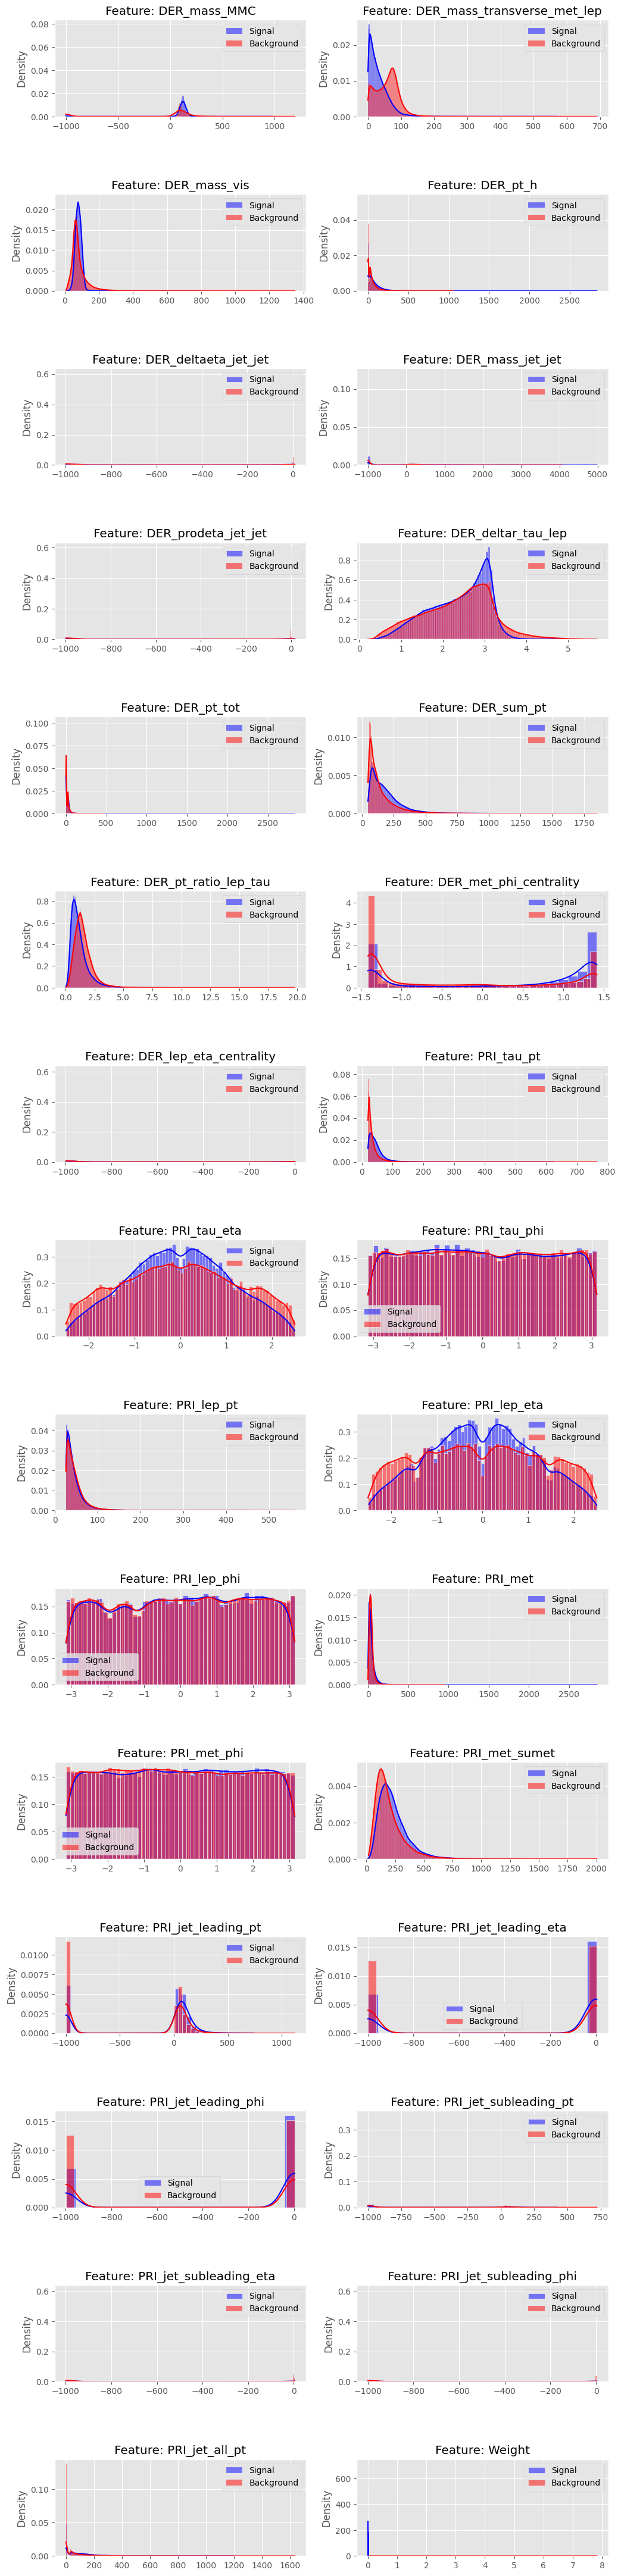

In [21]:
# Comparacion via Densidad
features = df.drop(["Label", "PRI_jet_num"], axis=1)
df["Label"] = df["Label"].factorize()[0]

plt.figure(figsize=(12, 120))
gs = gridspec.GridSpec(32, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Usando histplot para los casos donde Label == s
    sns.histplot(data=df[df["Label"] == 0], x=f, kde=True, color="blue", stat="density", label="Signal", alpha=0.5)
    # Usando histplot para los casos donde Label == b
    sns.histplot(data=df[df["Label"] == 1], x=f, kde=True, color="red", stat="density", label="Background", alpha=0.5)
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f}")
    ax.legend()

plt.show()

## 5. Calculo de correlaciones

In [22]:
# Calculamos correlaciones
df["Label"] = df["Label"].factorize()[0]
corr_matrix = df.corr(method="spearman")
corr_matrix["Label"].sort_values(ascending=False)

Label                          1.000000
Weight                         0.824648
DER_mass_transverse_met_lep    0.389563
DER_pt_ratio_lep_tau           0.266522
PRI_met                        0.054814
PRI_lep_pt                     0.045960
DER_pt_tot                     0.017300
PRI_tau_phi                    0.004395
PRI_tau_eta                    0.000551
PRI_lep_eta                   -0.002692
PRI_lep_phi                   -0.004061
PRI_met_phi                   -0.007484
DER_deltar_tau_lep            -0.020519
DER_prodeta_jet_jet           -0.107309
PRI_jet_leading_eta           -0.131833
PRI_jet_leading_phi           -0.131846
PRI_jet_subleading_phi        -0.137860
PRI_jet_subleading_eta        -0.138703
PRI_jet_subleading_pt         -0.140670
DER_mass_vis                  -0.145401
PRI_jet_num                   -0.151770
DER_mass_jet_jet              -0.167430
DER_lep_eta_centrality        -0.170461
DER_deltaeta_jet_jet          -0.171008
PRI_met_sumet                 -0.176103


In [23]:
df.corr(method="spearman")

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
DER_mass_MMC,1.000000,-0.220739,0.667968,0.177755,0.112972,0.111197,0.097528,0.446175,0.033495,0.305936,...,0.152178,0.162386,0.143010,0.144665,0.104640,0.105553,0.104811,0.160458,-0.260744,-0.318365
DER_mass_transverse_met_lep,-0.220739,1.000000,0.106169,-0.312263,-0.220082,-0.222702,-0.191605,0.039784,-0.033817,-0.230117,...,-0.267018,-0.304877,-0.228812,-0.226385,-0.212728,-0.205866,-0.205055,-0.299374,0.504113,0.389563
DER_mass_vis,0.667968,0.106169,1.000000,-0.086651,-0.061822,-0.067648,-0.065389,0.592098,-0.023775,0.136481,...,-0.068506,-0.088022,-0.043349,-0.040948,-0.073384,-0.063981,-0.063828,-0.087177,-0.010165,-0.145401
DER_pt_h,0.177755,-0.312263,-0.086651,1.000000,0.540929,0.551853,0.539249,-0.488339,0.375494,0.805124,...,0.769568,0.865534,0.675107,0.673608,0.563689,0.542335,0.541423,0.849246,-0.478262,-0.191302
DER_deltaeta_jet_jet,0.112972,-0.220082,-0.061822,0.540929,1.000000,0.994185,0.930767,-0.298138,0.195623,0.689668,...,0.809638,0.625918,0.448219,0.449237,0.960030,0.961768,0.961990,0.741905,-0.411521,-0.171008
DER_mass_jet_jet,0.111197,-0.222702,-0.067648,0.551853,0.994185,1.000000,0.932718,-0.310055,0.206766,0.705799,...,0.813432,0.647442,0.448335,0.449391,0.974020,0.961814,0.961852,0.758150,-0.412647,-0.167430
DER_prodeta_jet_jet,0.097528,-0.191605,-0.065389,0.539249,0.930767,0.932718,1.000000,-0.297001,0.233425,0.691455,...,0.816968,0.622740,0.448185,0.449043,0.960696,0.961989,0.962118,0.743371,-0.362724,-0.107309
DER_deltar_tau_lep,0.446175,0.039784,0.592098,-0.488339,-0.298138,-0.310055,-0.297001,1.000000,-0.122927,-0.371489,...,-0.367983,-0.457385,-0.289373,-0.286912,-0.322443,-0.299408,-0.298582,-0.444967,0.166632,-0.020519
DER_pt_tot,0.033495,-0.033817,-0.023775,0.375494,0.195623,0.206766,0.233425,-0.122927,1.000000,0.242385,...,0.263318,0.212931,0.149829,0.152331,0.238656,0.216398,0.215508,0.247069,-0.172859,0.017300
DER_sum_pt,0.305936,-0.230117,0.136481,0.805124,0.689668,0.705799,0.691455,-0.371489,0.242385,1.000000,...,0.876190,0.911767,0.706265,0.706508,0.722039,0.692510,0.691899,0.930406,-0.502280,-0.212398


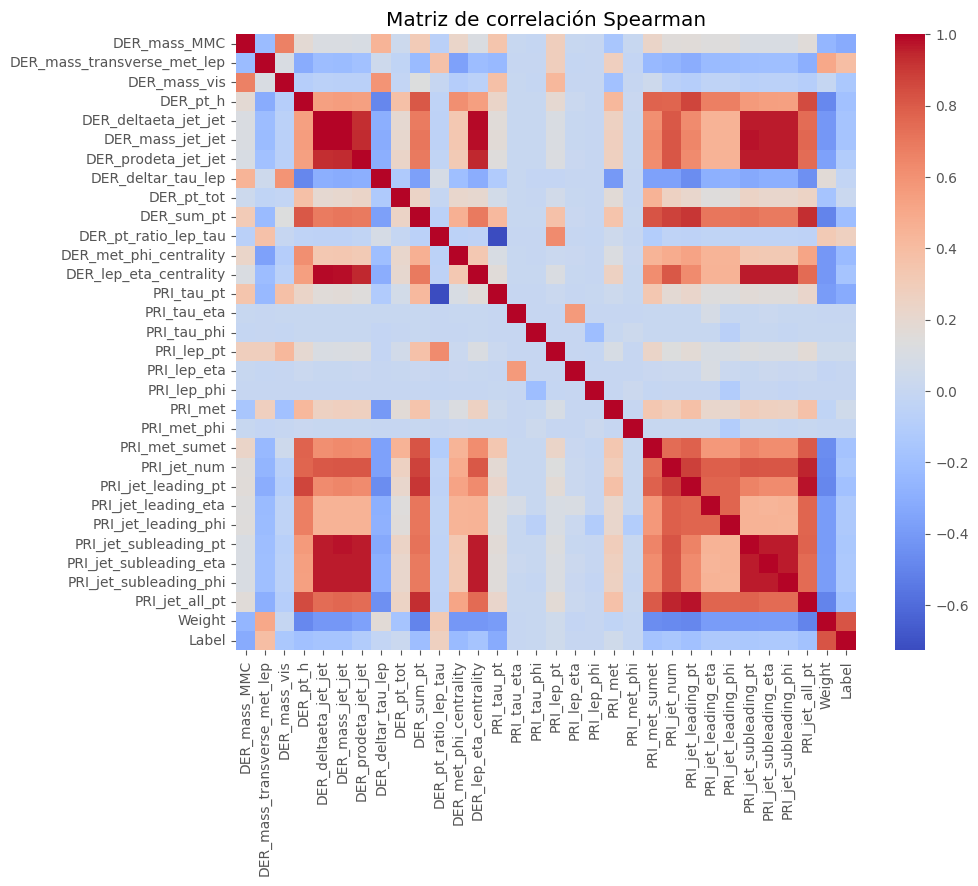

In [24]:
# Heatmap de la matriz de correlacion
corr = df[df.columns].corr(method="spearman")
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Matriz de correlación Spearman")
plt.show()

## 6. Seleccion de características

In [25]:
X = df.drop("Label", axis=1)
y = df["Label"].copy()

In [26]:
# Utilizamos Random Forest para realizar selección de características
from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X, y)

,n_estimators,50
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
# Seleccionamos las características más importantes
feature_importances = {name: score for name, score in zip(list(df), clf_rnd.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)

In [28]:
# Reducimos el conjunto de datos a las 7 características más importantes
X_reduced = X[list(feature_importances_sorted.head(7).index)].copy()

In [29]:
X_reduced

,Weight,DER_mass_MMC,DER_mass_transverse_met_lep,DER_met_phi_centrality,DER_mass_vis,PRI_tau_pt,DER_pt_ratio_lep_tau
EventId,,,,,,,
100000,0.002653,138.470,51.655,1.396,97.827,32.638,1.582
100001,2.233584,160.937,68.768,1.414,103.235,42.014,0.879
100002,2.347389,-999.000,162.172,1.414,125.953,32.154,3.776
100003,5.446378,143.905,81.417,-1.285,80.943,22.647,2.354
100004,6.245333,175.864,16.915,-1.385,134.805,28.209,1.056
...,...,...,...,...,...,...,...
349995,4.505083,-999.000,71.989,-1.414,36.548,24.754,1.258
349996,2.497259,-999.000,58.179,-1.345,68.083,23.416,1.162
349997,0.018636,105.457,60.526,0.529,75.839,35.636,1.202


In [30]:
df_reduced = X_reduced.join(y)

In [31]:
df_reduced.describe()

,Weight,DER_mass_MMC,DER_mass_transverse_met_lep,DER_met_phi_centrality,DER_mass_vis,PRI_tau_pt,DER_pt_ratio_lep_tau,Label
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,1.646767,-49.023079,49.239819,-0.128305,81.181982,38.707419,1.437609,0.657332
std,1.875103,406.345647,35.344886,1.193585,40.828691,22.412081,0.844743,0.474603
min,0.001502,-999.000000,0.000000,-1.414000,6.329000,20.000000,0.047000,0.000000
25%,0.018636,78.100750,19.241000,-1.371000,59.388750,24.591750,0.883000,0.000000
50%,1.156188,105.012000,46.524000,-0.356000,73.752000,31.804000,1.280000,1.000000
75%,2.404128,130.606250,73.598000,1.225000,92.259000,45.017000,1.777000,1.000000
max,7.822543,1192.026000,690.075000,1.414000,1349.351000,764.408000,19.773000,1.000000


### 6.1 Gráficas del conjunto de datos reducido

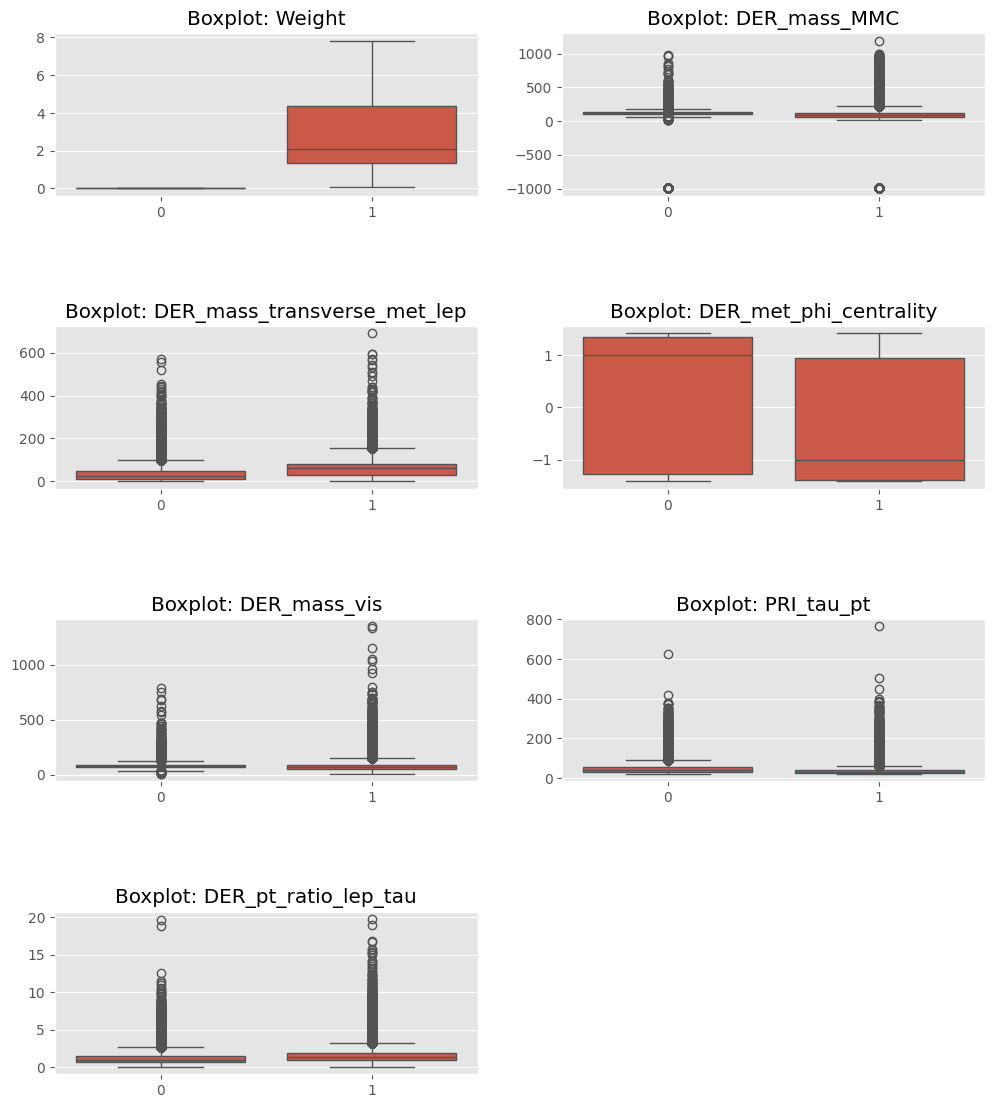

In [32]:
# Comparacion via Boxplot
features = df_reduced.drop("Label", axis=1)

plt.figure(figsize=(12, 120))
gs = gridspec.GridSpec(32, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.boxplot(data=df_reduced, x="Label", y=f, ax=ax)
    ax.set_xlabel('')  
    ax.set_ylabel('') 
    ax.set_title(f"Boxplot: {f}")

plt.show()

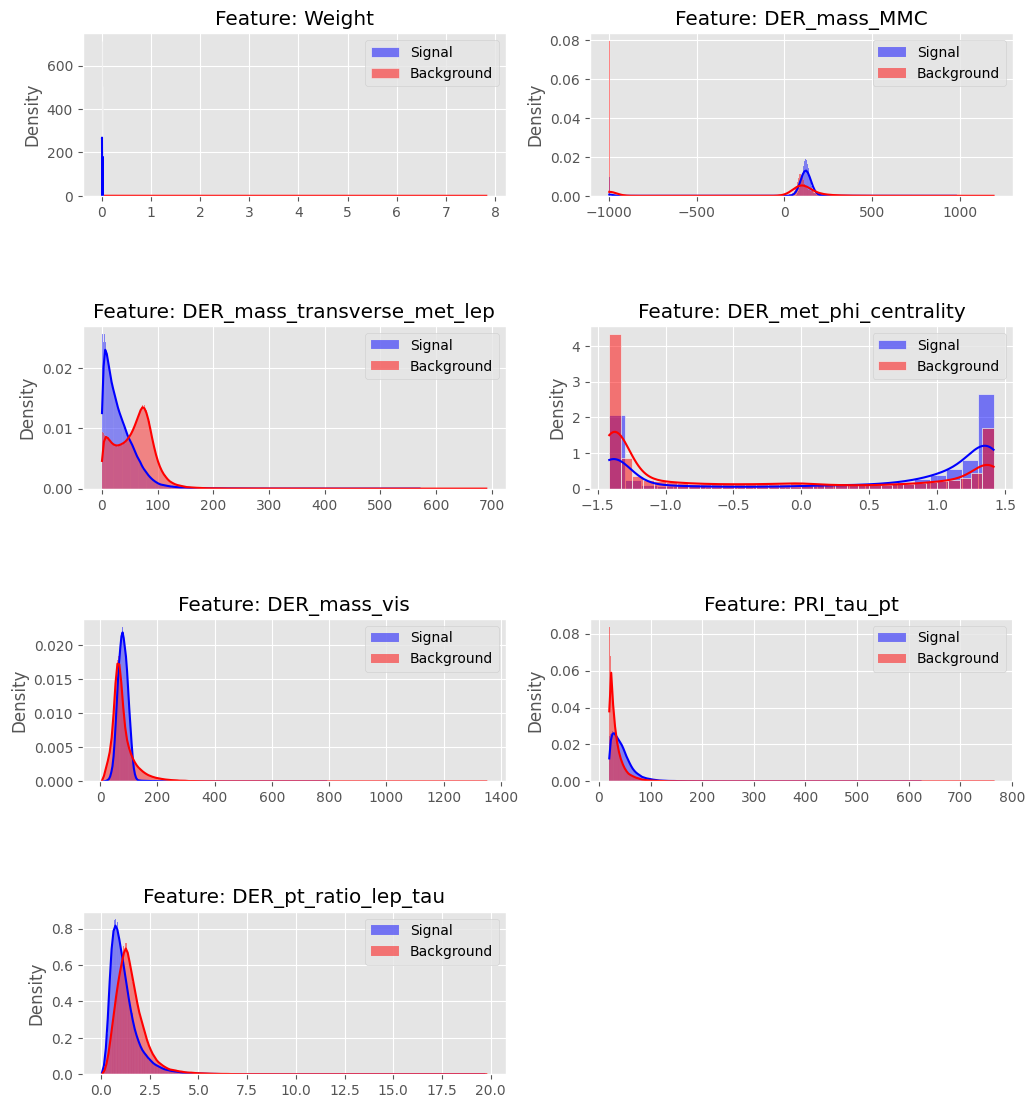

In [33]:
# Comparacion via Densidad
features = df_reduced.drop("Label", axis=1)

plt.figure(figsize=(12, 120))
gs = gridspec.GridSpec(32, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Usando histplot para los casos donde Label == s
    sns.histplot(data=df_reduced[df_reduced["Label"] == 0], x=f, kde=True, color="blue", stat="density", label="Signal", alpha=0.5)
    # Usando histplot para los casos donde Label == b
    sns.histplot(data=df_reduced[df_reduced["Label"] == 1], x=f, kde=True, color="red", stat="density", label="Background", alpha=0.5)
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f}")
    ax.legend()

plt.show()

## 7. Escalado del conjunto de datos

In [34]:
# Usamos el transformador customScaler para escalar algunas características usando RobustScaler
custom_scaler_r = CustomScalerR([
                              "DER_mass_MMC",
                              "DER_mass_transverse_met_lep",
                              "DER_mass_vis",
                              "PRI_tau_pt",   
                              "DER_pt_ratio_lep_tau", 
                              ])
df_scaled = custom_scaler_r.fit_transform(df_reduced)

# Usamos el transformador customScaler para escalar algunas caracteristicas usando MinMaxScaler 
custom_scaler_minmax = CustomScalerMinMax([
    "Weight",
    "DER_met_phi_centrality"
])
df_scaled = custom_scaler_minmax.fit_transform(df_scaled)

In [35]:
df_scaled

,Weight,DER_mass_MMC,DER_mass_transverse_met_lep,DER_met_phi_centrality,DER_mass_vis,PRI_tau_pt,DER_pt_ratio_lep_tau,Label
EventId,,,,,,,,
100000,0.000147,0.637228,0.094394,0.993635,0.732425,0.040832,0.337808,0
100001,0.285395,1.065127,0.409221,1.000000,0.896951,0.499871,-0.448546,1
100002,0.299946,-21.026597,2.127564,1.000000,1.588093,0.017136,2.791946,1
100003,0.696183,0.740741,0.641923,0.045615,0.218769,-0.448318,1.201342,1
100004,0.798338,1.349421,-0.544714,0.010255,1.857394,-0.176008,-0.250559,1
...,...,...,...,...,...,...,...,...
349995,0.575829,-21.026597,0.468477,0.000000,-1.131844,-0.345161,-0.024609,1
349996,0.319108,-21.026597,0.214416,0.024399,-0.172466,-0.410668,-0.131991,1
349997,0.002191,0.008475,0.257593,0.687058,0.063492,0.187611,-0.087248,0


### 7.1 Gráficas del conjunto de datos escalado

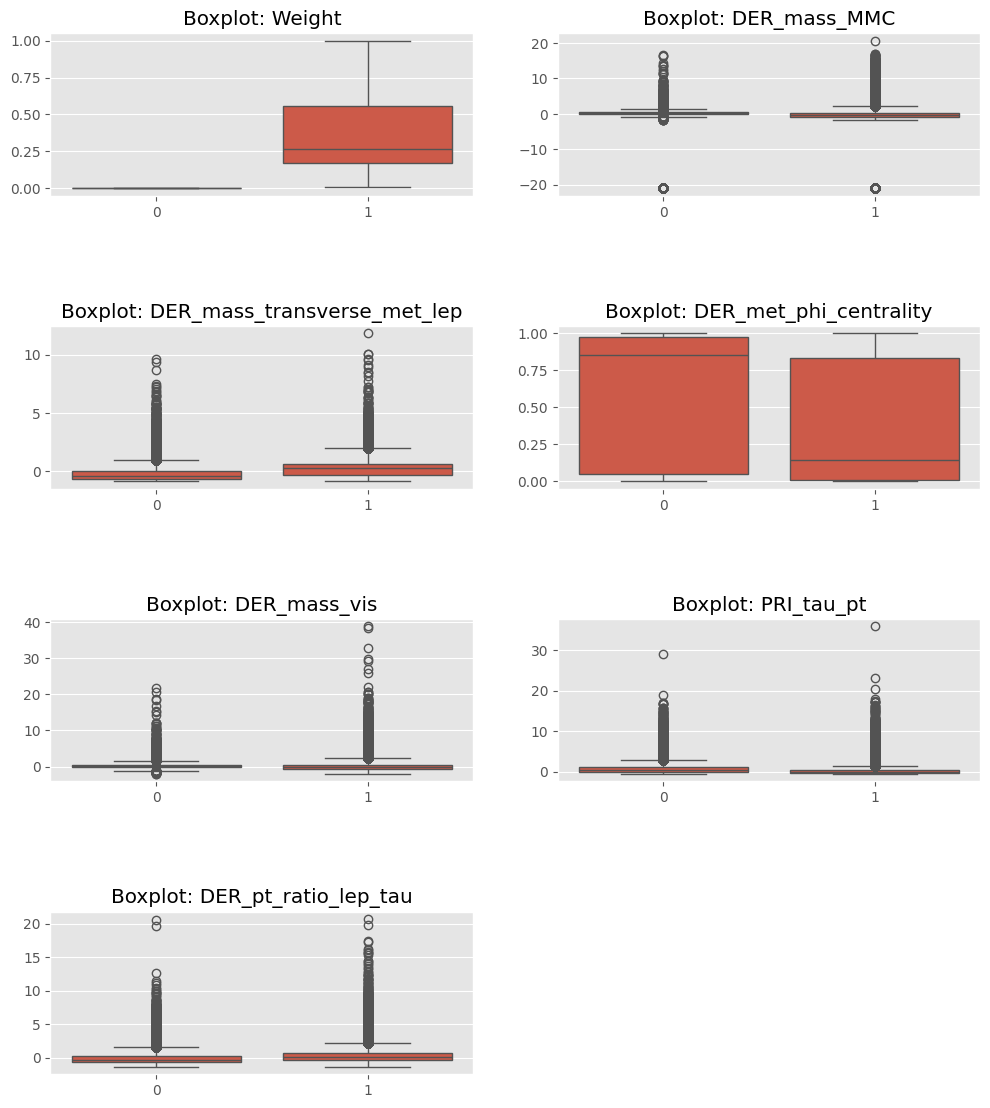

In [36]:
# Comparacion via Boxplot
features = df_scaled.drop("Label", axis=1)

plt.figure(figsize=(12, 120))
gs = gridspec.GridSpec(32, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.boxplot(data=df_scaled, x="Label", y=f, ax=ax)
    ax.set_xlabel('')  
    ax.set_ylabel('') 
    ax.set_title(f"Boxplot: {f}")

plt.show()

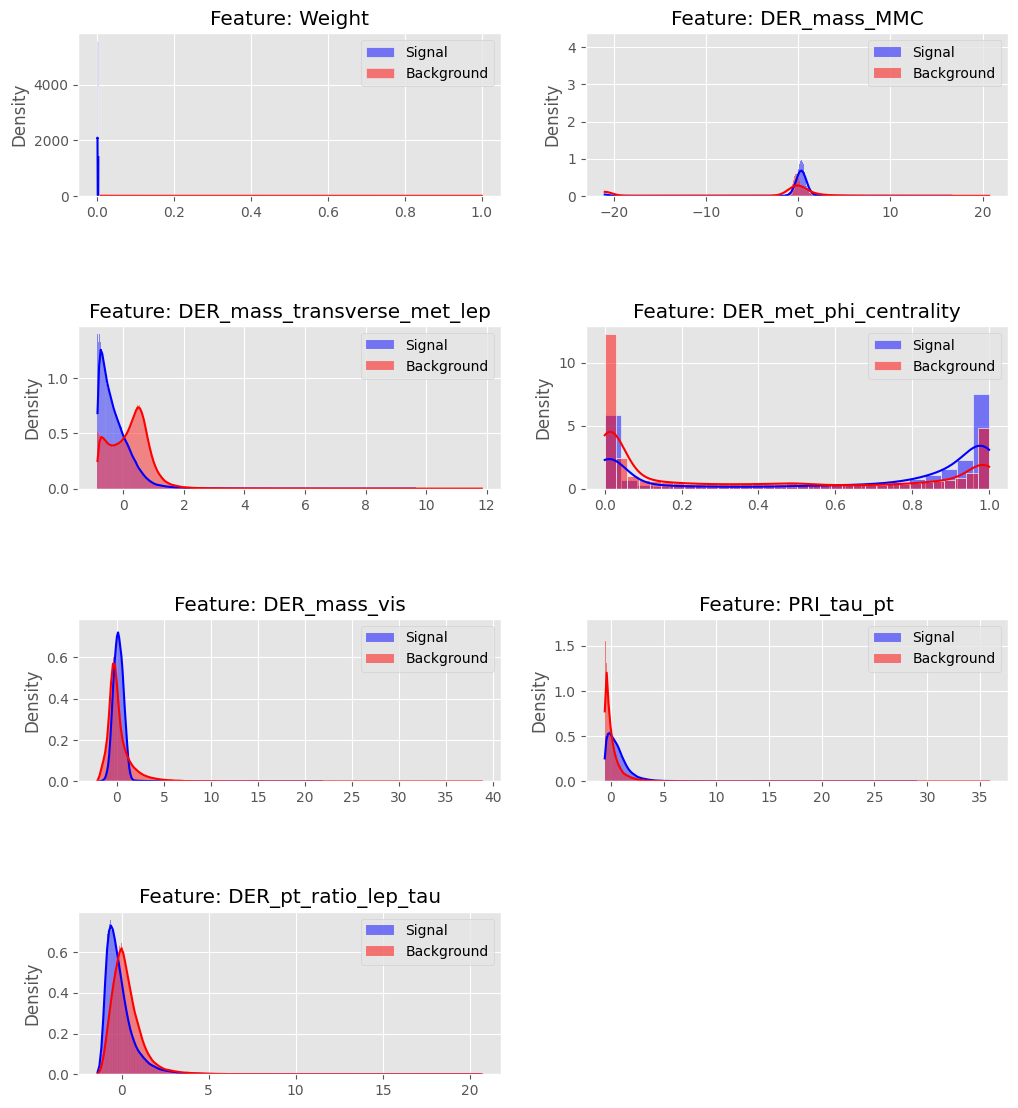

In [37]:
# Comparacion via Densidad
features = df_scaled.drop("Label", axis=1)

plt.figure(figsize=(12, 120))
gs = gridspec.GridSpec(32, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Usando histplot para los casos donde Label == "s"
    sns.histplot(data=df_scaled[df_scaled["Label"] == 0], x=f, kde=True, color="blue", stat="density", label="Signal", alpha=0.5)
    # Usando histplot para los casos donde Label == "b"
    sns.histplot(data=df_scaled[df_scaled["Label"] == 1], x=f, kde=True, color="red", stat="density", label="Background", alpha=0.5)
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f}")
    ax.legend()

plt.show()

## 8. División del conjunto de datos

In [38]:
df_prepared = df_reduced

In [39]:
# Se separa el conjunto de datos en tres subconjuntos: Entrenamiento, Validación y Pruebas
train_set, val_set, test_set = train_val_test_split(df_prepared)

In [40]:
# Se separan las etiquetas de entrada y de salida
X_df = df_prepared.drop(["Label"], axis=1)
y_df = df_prepared["Label"].copy()

X_train = train_set.drop(["Label"], axis=1)
y_train = train_set["Label"].copy()

X_val = val_set.drop(["Label"], axis=1)
y_val = val_set["Label"].copy()

X_test = test_set.drop(["Label"], axis=1)
y_test = test_set["Label"].copy()

## 9. Entrenamiento de un algoritmo de regresión logística

In [41]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [42]:
# Predecimos con el conjunto de datos de validación
y_pred_val = clf.predict(X_val)
y_pred_val

array([1, 1, 1, ..., 1, 1, 0], shape=(50000,))

In [43]:
# Comparación de valores predecido y reales
print("Predicción:\n", y_pred_val[:10])
print("\nEtiquetas reales:\n", y_val[:10])

Predicción:
 [1 1 1 1 1 1 1 1 1 0]

Etiquetas reales:
 EventId
154735    1
288997    1
268743    1
199064    1
196572    1
129936    1
183666    1
245843    1
141199    1
347643    0
Name: Label, dtype: int64


In [44]:
from sklearn.metrics import accuracy_score

print('Accuracy para el Conjunto de datos de Validación: {:.3f}'.format(accuracy_score(y_val, y_pred_val)))

Accuracy para el Conjunto de datos de Validación: 0.999


In [45]:
# Predecimos con el conjunto de datos de prueba
y_pred_test = clf.predict(X_test)
y_pred_test

array([1, 0, 1, ..., 1, 1, 1], shape=(50000,))

In [46]:
# Comparación de valores predecido y reales

print("Predicción:\n", y_pred_test[:10])
print("\nEtiquetas reales:\n", y_test[:10])

Predicción:
 [1 0 1 1 0 1 1 0 1 0]

Etiquetas reales:
 EventId
127775    1
271723    0
336563    1
267178    1
198807    0
292177    1
100102    1
238858    0
296554    1
137614    0
Name: Label, dtype: int64


In [47]:
print('Accuracy para el Conjunto de datos de Prueba: {:.3f}'.format(accuracy_score(y_test, y_pred_test)))

Accuracy para el Conjunto de datos de Prueba: 0.999


# Particle Event Classification: RNA

## 1. División del conjunto de datos

In [48]:
train_set, val_set, test_set = train_val_test_split_deep(df_prepared)

In [49]:
train_set.shape

(245000, 8)

In [50]:
val_set.shape

(2500, 8)

In [51]:
test_set.shape

(2500, 8)

### 1.1 Separación de etiquetas

In [52]:
X_train_red, y_train_red = remove_labels(train_set, "Label")
X_val_red, y_val_red = remove_labels(val_set, "Label")
X_test_red, y_test_red = remove_labels(test_set, "Label")

## 2. Definición de la red neuronal

In [53]:
network = models.Sequential()

network.add(layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]))
network.add(layers.Dense(10, activation='relu'))
network.add(layers.Dense(1, activation="sigmoid"))

C:\Users\luis2\anaconda3\envs\c_machine_learning\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
from tensorflow.keras import optimizers

network.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision']
)

In [55]:
network.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 561 (2.19 KB)

 Trainable params: 561 (2.19 KB)

 Non-trainable params: 0 (0.00 B)

### 2.1 Acceso a los elemento definidos de la RNA

In [56]:
network.layers

[<Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [57]:
hidden1 = network.layers[1]

In [58]:
weights, biases = hidden1.get_weights()

In [59]:
weights

array([[-0.11768925, -0.30168614,  0.06825081, -0.3585804 ,  0.25574684,
         0.00235438,  0.23714697, -0.18614763, -0.3055001 ,  0.25105458],
       [ 0.10810399,  0.37441707, -0.17741808, -0.33090362, -0.3552732 ,
        -0.01432595, -0.21677883,  0.11736876, -0.24579787,  0.13678545],
       [-0.23169197, -0.06734809,  0.08988604, -0.20789424,  0.10630697,
        -0.3317788 , -0.37486118, -0.2491787 ,  0.12746465,  0.1183179 ],
       [ 0.28422982, -0.09530708,  0.04989323,  0.07388717,  0.32737207,
        -0.33741453, -0.17260785, -0.1715527 , -0.15857342,  0.09345689],
       [-0.36524427,  0.21761471, -0.2814691 ,  0.11936069, -0.16879942,
        -0.19412537, -0.22033048, -0.23967256,  0.2265091 ,  0.27683234],
       [ 0.2532187 , -0.13398322,  0.18497097,  0.01178542, -0.29507935,
        -0.25575185, -0.2755607 , -0.06665149, -0.36924735, -0.32537758],
       [-0.31628293, -0.32826364, -0.28610915, -0.11127308, -0.20521381,
         0.0475671 , -0.10492808, -0.30639654

In [60]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## 4. Entrenamiento de la red neuronal artificial

In [61]:
history = network.fit(
    X_train_red, 
    y_train_red,                   
    epochs=30, 
    validation_data=(X_val_red, y_val_red))

Epoch 1/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 9s 864us/step - Precision: 0.9597 - accuracy: 0.9055 - loss: 0.2522 - val_Precision: 0.9973 - val_accuracy: 0.9384 - val_loss: 0.1570
Epoch 2/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 6s 825us/step - Precision: 0.9919 - accuracy: 0.9657 - loss: 0.1030 - val_Precision: 0.9994 - val_accuracy: 0.9612 - val_loss: 0.0932
Epoch 3/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 6s 839us/step - Precision: 0.9959 - accuracy: 0.9895 - loss: 0.0469 - val_Precision: 0.9921 - val_accuracy: 0.9928 - val_loss: 0.0241
Epoch 4/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 6s 825us/step - Precision: 0.9975 - accuracy: 0.9937 - loss: 0.0241 - val_Precision: 0.9994 - val_accuracy: 0.9928 - val_loss: 0.0241
Epoch 5/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 6s 821us/step - Precision: 0.9983 - accuracy: 0.9955 - loss: 0.0163 - val_Precision: 0.9969 - val_accuracy: 0.9960 - val_loss: 0.0183
Epoch 6/30
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 6s 830us/step - Precision: 0.9988 - accuracy: 0.9956 - loss: 0.0157 - val_Prec

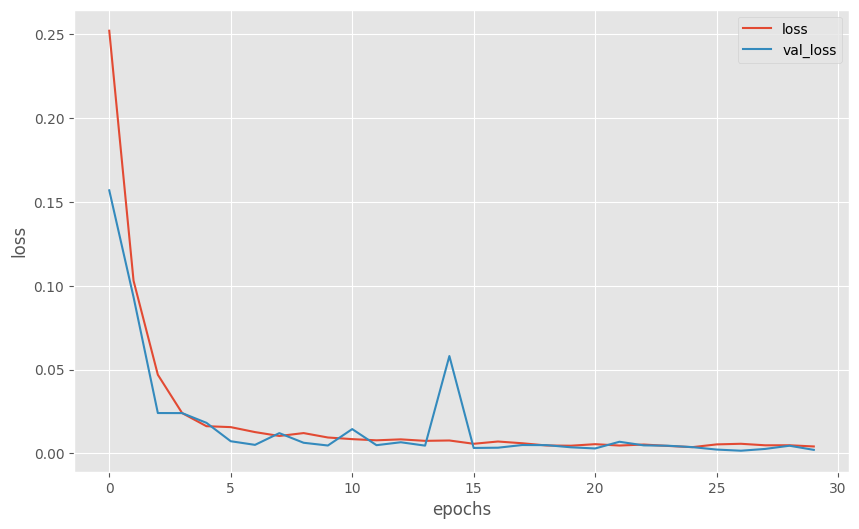

In [77]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

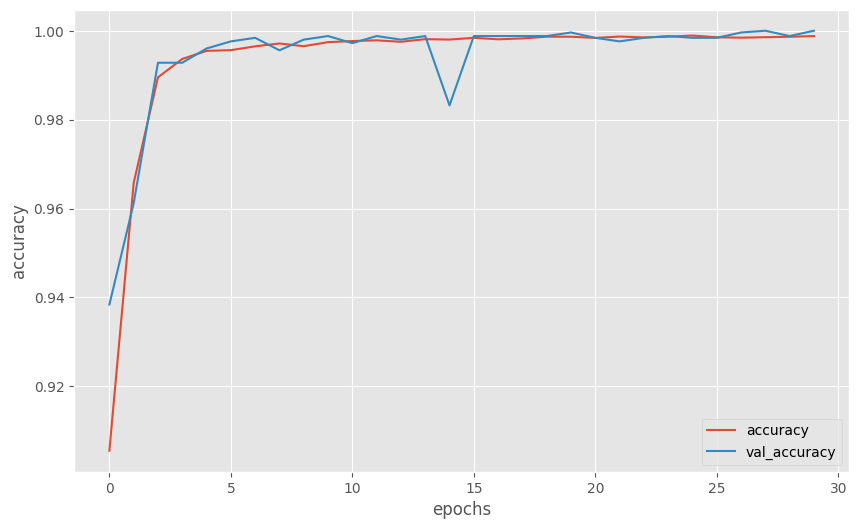

In [78]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

## 5. Validación con el conjunto de datos de pruebas

In [63]:
# Relizamos la prediccion
y_predict = network.predict(X_test_red)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step


In [64]:
y_predict

array([[1.0000000e+00],
       [6.2870895e-06],
       [1.0000000e+00],
       ...,
       [1.0000000e+00],
       [2.2900301e-06],
       [2.5140339e-06]], shape=(2500, 1), dtype=float32)

In [76]:
# Comparamos la predicción con el valor original
print("Predicción:", y_predict[:10])

Predicción: [[1.0000000e+00]
 [6.2870895e-06]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [2.3863629e-06]
 [9.9848074e-01]
 [2.3577106e-06]]


In [84]:
print("Valor original:", y_test[:10])

Valor original: EventId
127775    1
271723    0
336563    1
267178    1
198807    0
292177    1
100102    1
238858    0
296554    1
137614    0
Name: Label, dtype: int64


In [81]:
test_loss, test_acc, test_prec = network.evaluate(X_test_red, y_test_red)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - Precision: 1.0000 - accuracy: 0.9996 - loss: 0.0021    


In [82]:
print('test_acc:', test_acc)
print('test_prec:', test_prec)

test_acc: 0.9995999932289124
test_prec: 1.0
